In [49]:
%env CUDA_VISIBLE_DEVICES=2

import os
import sys

import torch
import pickle
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, "/notebooks/goryachev/petroflow")

from petroflow import WellDataset, WS
from petroflow.batchflow import Pipeline, B, V, C
from petroflow.batchflow.research import Research
from petroflow.batchflow.models.torch import UNet
from petroflow.models.logs_prediction.utils import build_dataset, calc_metrics, batch_mse, moving_average_1d

env: CUDA_VISIBLE_DEVICES=2


In [2]:
FILTERED_DATASET_PATH = "../data/filtered/*"
filtered_dataset = WellDataset(path=FILTERED_DATASET_PATH, dirs=True)

In [3]:
INPUTS_COL = ['GK', 'NKTD', 'GZ1', "DEPTH KM"]
TARGET_COL = ['DT']
PROPER_COL = INPUTS_COL + TARGET_COL

In [4]:
N_CROPS = 8
CROP_SIZE = 64
REINDEXATION_STEP = 0.1
CROP_LENGTH = CROP_SIZE * REINDEXATION_STEP

In [5]:
split_pipeline = filtered_dataset >> Pipeline().drop_nans()
batch = split_pipeline.next_batch(filtered_dataset.size)
dataset = build_dataset(batch)
dataset.split(shuffle=11)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [55]:
load_config = {'load/path': 'results/model',
               'device': torch.device('cuda:0')}

test_template = (Pipeline()
    .add_namespace(np)
    .crop(CROP_LENGTH, CROP_LENGTH)
    .update(B('inputs'), WS('logs')[INPUTS_COL].values.ravel())
    .stack(B("inputs"), save_to=B("inputs"))
    .swapaxes(B("inputs"), 1, 2, save_to=B("inputs"))
    .array(B("inputs"), dtype=np.float32, save_to=B("inputs"))
    .update(B('target'), WS('logs')[TARGET_COL].values.ravel())
    .stack(B("target"), save_to=B("target"))
    .swapaxes(B("target"), 1, 2, save_to=B("target"))
    .array(B("target"), dtype=np.float32, save_to=B("target"))
    .init_variable('targets', default=[])
    .update(V('targets', mode='a'), B('target'))
    .init_variable('predictions', default=[])
    .init_model('dynamic', UNet, 'unet', load_config)
    .predict_model('unet', B('inputs'), fetches='predictions', save_to=V('predictions', mode='a'))
)

## Metrics evaluation

Two metrics used for model evaluation:
* Mean absolute error (MAE)
* Proportion of variance explained by model to data variance (R^2)

In [56]:
test_pipeline = dataset.test >> test_template
test_pipeline.run(batch_size=1, n_iters=1, shuffle=True, drop_last=False)

true = np.concatenate([target.flatten() for target in test_pipeline.v('targets')])
pred = np.concatenate([prediction.flatten() for prediction in test_pipeline.v('predictions')])

metrics = calc_metrics(true, pred)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



MSE: 0.332
R^2: 0.669


Plot several randomly chosen predictions.

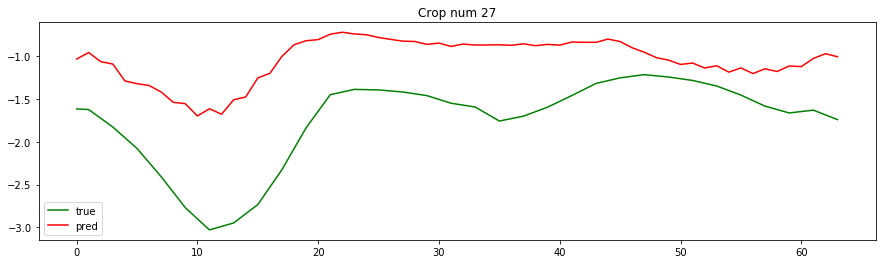

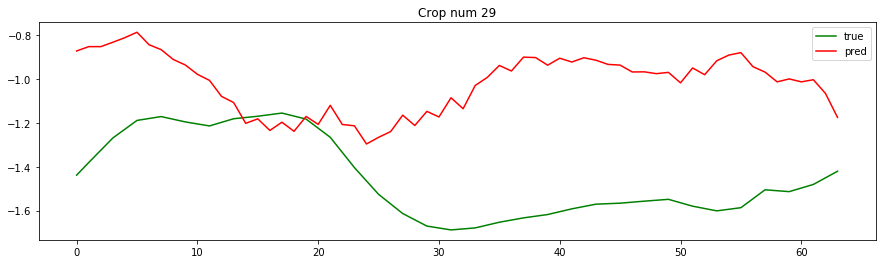

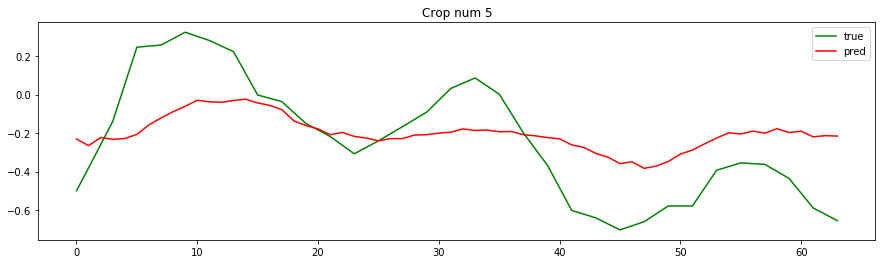

In [57]:
BATCH_NUM = np.random.randint(len(test_pipeline.v('predictions')))
GRAPH_NUM = test_pipeline.v('predictions')[BATCH_NUM].shape[0]
PRINT_NUM = 3
for crop_num in np.random.choice(GRAPH_NUM, PRINT_NUM, replace=False):
    true = test_pipeline.v('targets')[BATCH_NUM][crop_num, 0, :]
    pred = test_pipeline.v('predictions')[BATCH_NUM][crop_num, 0,:]

    fig = plt.figure(figsize=(15, 4))
    plt.title("Crop num {}".format(crop_num))
    plt.plot(true, 'g')
    plt.plot(pred, 'r')
    plt.legend(['true', 'pred'])
    plt.show()

Calculate metrics on whole test dataset

In [58]:
BATCH_SIZE = 16
test_pipeline = dataset.test >> test_template
test_pipeline.run(batch_size=BATCH_SIZE, n_iters=1, drop_last=False, bar='n')

true = np.concatenate([target.flatten() for target in test_pipeline.v('targets')])
pred = np.concatenate([prediction.flatten() for prediction in test_pipeline.v('predictions')])

metrics = calc_metrics(true, pred)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



MSE: 0.688
R^2: 0.286


In [66]:
compare_results(metrics)

Reproduced model metrics DO NOT match saved:

Saved metrics:      MSE: 0.605, R^2: 0.381
Reproduced metrics: MSE: 0.688, R^2: 0.286


## Conclusion

For some reason model was not reproduced succesfully.